In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [34]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pass
        # Implement this!
        best_action = np.argmax(Q[observation])
        A_prob = (1-epsilon)*np.eye(nA)[best_action]
        A_random = (epsilon/nA)*(np.ones(nA))
        return A_prob + A_random
    return policy_fn

In [56]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    def  update(states,rewards, actions,returns_sum,returns_count):
        # assert就是好啊，认真看bug会死啊！
        assert(len(states) ==len(rewards) ==len(actions))
        length  = len(states)
        for i,state in enumerate(states):
            returns_sum[state] +=1
            discount =1
            for j in range(i,length):
                returns_count[state] +=discount*rewards[j]
                discount = discount*discount_factor
            Q[state][actions[i]] = returns_count[state]/returns_sum[state]

                

    for i_episode in range(num_episodes):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        observation = env.reset()
        states = []
        rewards = []
        actions = []
        for t in range(100):
            # print("t", t)
            states.append(observation)
            action_probs = policy(observation)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            actions.append(action)
            observation, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        ## evalution
        update(states,rewards, actions,returns_sum,returns_count)
        ## improvement
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

        
    
    return Q, policy

In [57]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

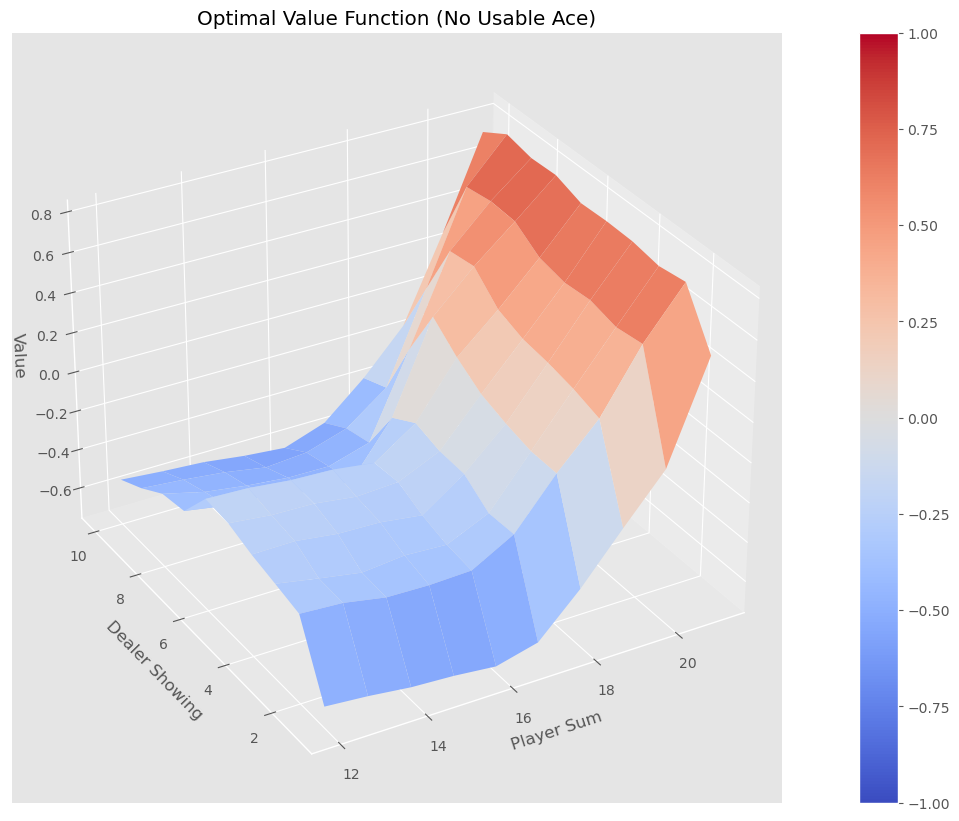

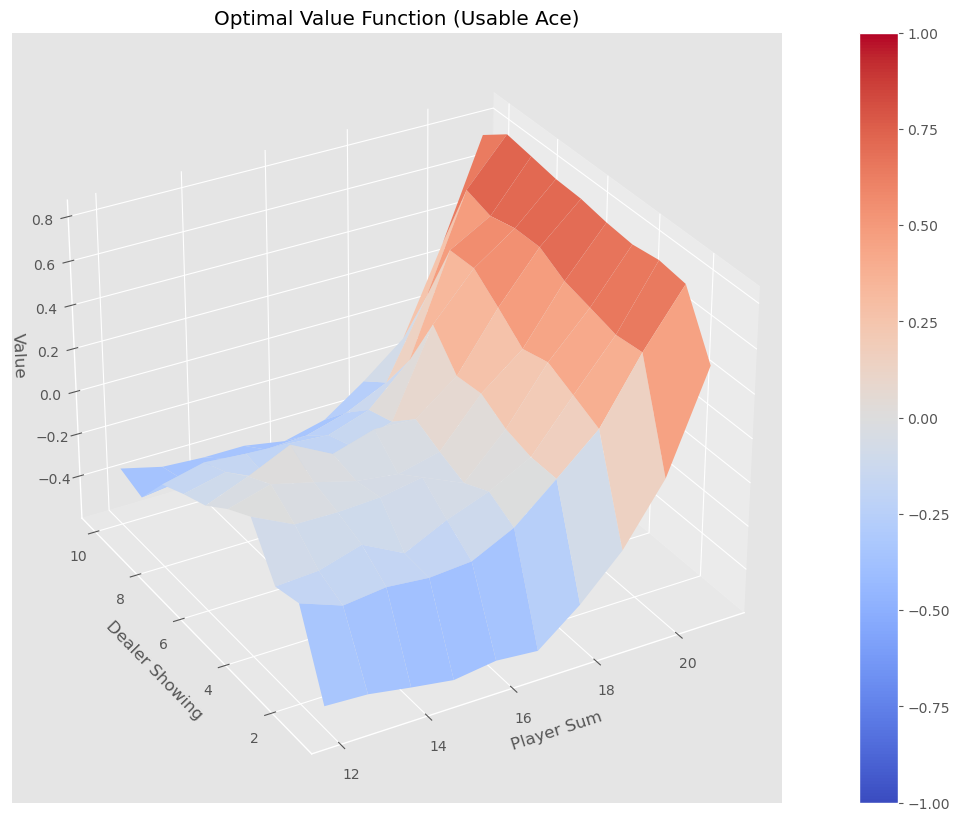

In [58]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")